In [1]:
import os

import pandas
import numpy
import matplotlib.pyplot as plt

from ProblemInstance import ProblemInstance
from baseline_intra import bl_intra_1
from baseline_request import bl_req_FCFS
from our_approach import leader_follower

In [2]:
def get_time_per_model(problem, plan):
    return problem.running_time_decompose(*problem.get_pc_packages_from_plan(*plan))["read latency per model"]
def get_time(problem, plan):
    return problem.running_time_decompose(*problem.get_pc_packages_from_plan(*plan))["read latency"]

In [3]:
fontsize = 15
colors = ['lightgoldenrodyellow','darkorange','slategray','darkcyan','wheat','dimgrey',
          'navy','steelblue','lime','darkgrey','indianred','mediumturquoise',
          'lavenderblush','palegreen','grey','sandybrown','yellowgreen','goldenrod']
neurosim_dir = "NetStructure"  # directory store network structure description file following NeuroSim
summary_file = "NeuroSIMOut/summary.csv"  # simulation result get from NeuroSim

In [4]:
seed = 10
n_req = 50000

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
multi_model_problem.get_random_requests_unequal(n_req, seed=seed)
read_time_pd = {m:[] for m in multi_model_problem.profile["DNN"]}
read_time_pd["name"] = []

plan_intra = bl_intra_1(multi_model_problem)
intra_read_time = get_time_per_model(multi_model_problem, plan_intra)
equal_workload_intra_time = []
for k in  multi_model_problem.profile["DNN"]:
    equal_workload_intra_time.append(intra_read_time[k])
p = 1/numpy.array(equal_workload_intra_time)
p = p/numpy.sum(p)
multi_model_problem.get_random_requests_unequal(n_req, seed=seed, p = p)
multi_model_problem.append_request()


plan_intra = bl_intra_1(multi_model_problem)
intra_read_time = get_time_per_model(multi_model_problem, plan_intra)
for k in  multi_model_problem.profile["DNN"]:
    read_time_pd[k].append(intra_read_time[k])
read_time_pd["name"].append("Intra")

package_inter = bl_req_FCFS(multi_model_problem) 
inter_read_time = multi_model_problem.running_time_decompose(*package_inter)["read latency per model"]
for k in  multi_model_problem.profile["DNN"]:
    read_time_pd[k].append(inter_read_time[k])
read_time_pd["name"].append("Inter")

plan_our = leader_follower(multi_model_problem)
our_read_time = get_time_per_model(multi_model_problem, plan_our)
for k in  multi_model_problem.profile["DNN"]:
    read_time_pd[k].append(our_read_time[k])
read_time_pd["name"].append("PIMShare")

read_time_pd = pandas.DataFrame(read_time_pd)

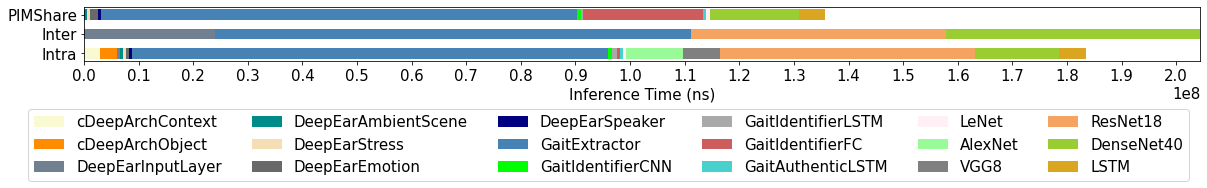

In [5]:
plt.figure(figsize=(20, 1))
names = ["Intra", "Inter", "PIMShare"]
n_col = 1
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+5)
bottom = numpy.zeros(3)
active_model = numpy.zeros(3)
for i, m in enumerate(multi_model_problem.profile["DNN"]):
    bar_heights = read_time_pd[m].to_numpy()
    bar_heights[numpy.isinf(bar_heights)] = 0
    plt.barh(base_xticks, bar_heights, height=width_per_col, label=m, left=bottom, color=colors[i])
    bottom += bar_heights
    active_model += read_time_pd[m].to_numpy() > 0
plt.yticks(ticks=base_xticks, labels=names, rotation=0, fontsize=fontsize)
plt.xticks(numpy.arange(0, max(bottom), step=1e7), fontsize=fontsize)
plt.gca().xaxis.offsetText.set_fontsize(fontsize)
plt.xlabel("Inference Time (ns)", fontdict={"size":fontsize})
plt.legend(loc=(-0.05, -2.2), ncol=6, fontsize=fontsize)
plt.show()